In [1]:

import os
import time
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchdyn

import ot as pot

from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

from random_processes import *
from models import *


savedir = "savedir/MaskedCFM"
os.makedirs(savedir, exist_ok=True)

In [2]:
# Seed initialization
def init_seed(use_fixed=True, fixed_seed=42):
    if use_fixed:
        seed = fixed_seed
    else:
        seed = int.from_bytes(os.urandom(64), "little")
    print(f"Using seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed


init_seed(use_fixed=True, fixed_seed=42)

Using seed: 42


42

In [3]:
lorenz_drift, lorenz_dif = make_lorenz_system(
    sigma=10.0, rho=28.0, beta=8/3, noise_scale=0.5
)

def lorenz_init_uniform(batch_size):
    return torch.empty(batch_size, 3).uniform_(-15, 15)

def lorenz_init_gaussian(batch_size):
    return torch.randn(batch_size, 3) * np.sqrt(100)

lorenz_sampler = TorchSDEDiffusionSampler(
    lorenz_drift,
    lorenz_dif,
    t0=0.0,
    t1=10.0,
    steps=5000,
    init_sampler=lorenz_init_uniform,
    method="euler",
)

traj, times, mean_traj = lorenz_sampler.sample(num_paths=5)
traj = traj.cpu().numpy()
times = times.cpu().numpy()
mean_traj = mean_traj.cpu().numpy()



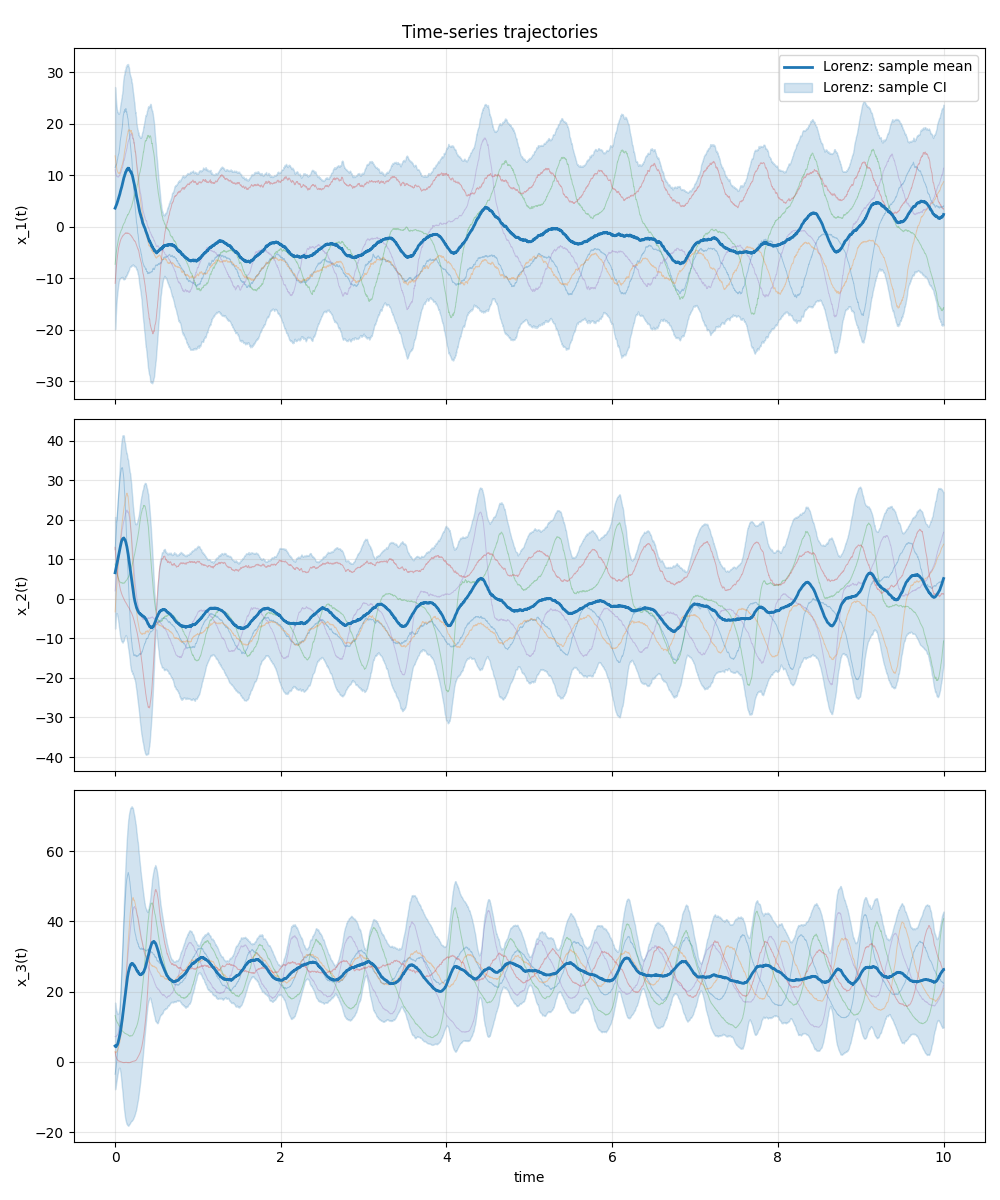

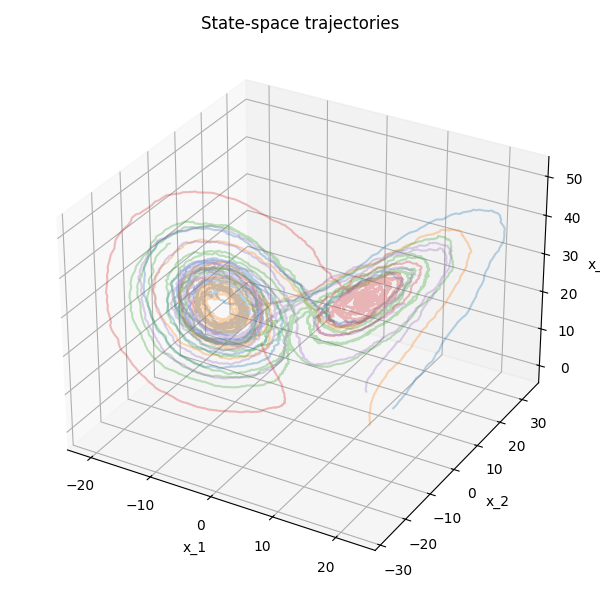

In [4]:
%matplotlib widget
plot_time_series(
    [(times,traj)],
    labels=["Lorenz"],
    dims=[0, 1, 2],
    plot_mean=True,
    plot_ci=True,
    ci_level=2.0,
    separate_dims=True,
    max_samples=5,
)

plot_state_space(
    [traj],
    proj_dims=(0,1,2),
    labels=["Lorenz samples"],
    max_samples=5,
    plot_mean=False,
    plot_median=False,
    plot_ci=False,
)

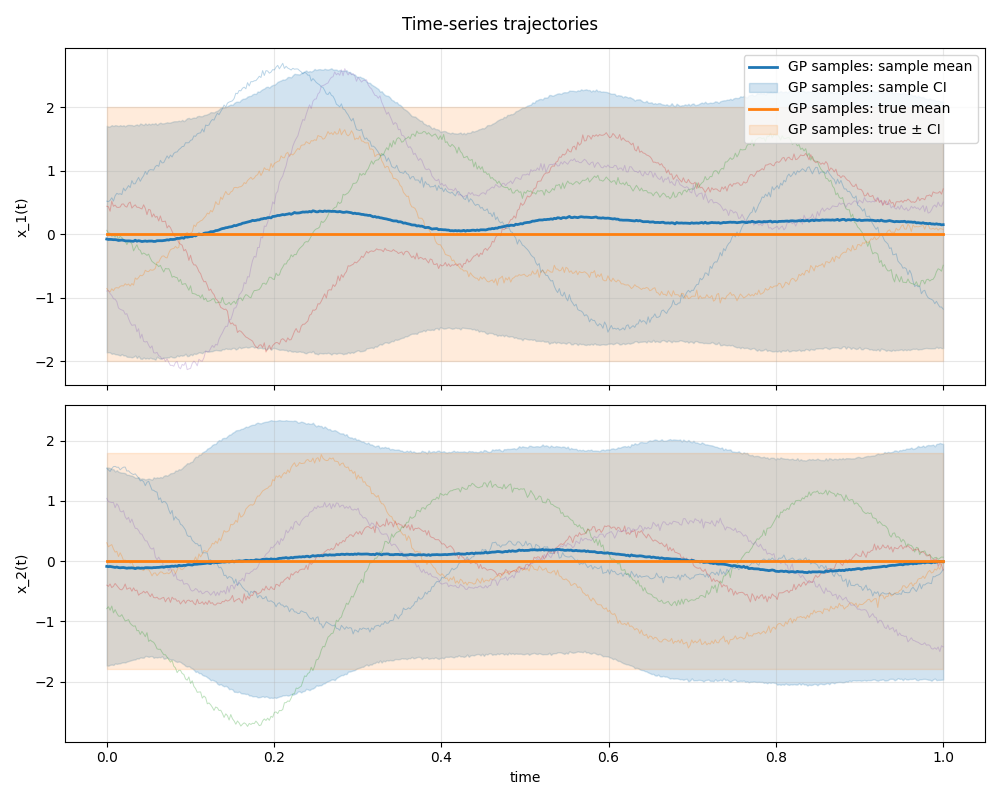

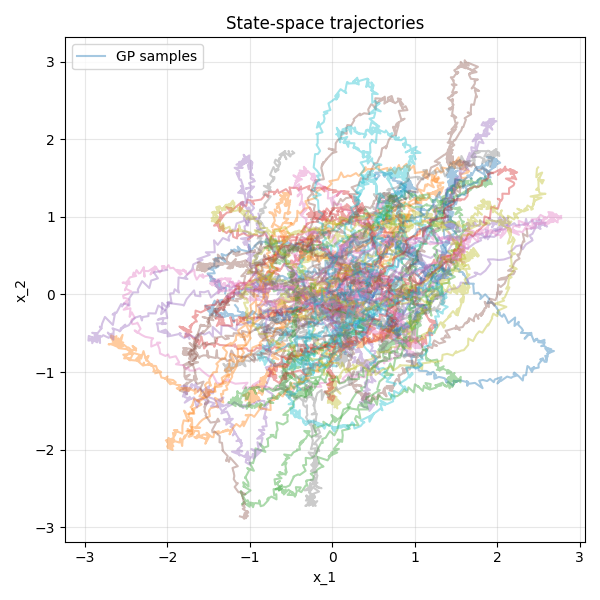

In [ ]:
%matplotlib widget

d = 2

def mean_fn(t):
    #amp = 1.0 + 0.5 * torch.sin(6 * 2 * torch.pi * t)
    #angle = torch.pi * t
    #return amp * torch.tensor([torch.cos(angle), torch.sin(angle)])
    x = t * 0.0
    return torch.tensor([x, x])


# def mean_fn(t):
#     # figure-eight mean
#     return torch.tensor([
#         torch.sin(2 * torch.pi * t),
#         torch.sin(4 * torch.pi * t) / 2
#     ])

# def cov_kernel(t, s):
#     dt = torch.abs(t - s)
#     base = torch.exp(-3.0 * dt)

#     mid = 0.5 * (t + s)
#     angle = torch.pi * mid
#     R = torch.tensor([[torch.cos(angle), -torch.sin(angle)],
#                       [torch.sin(angle),  torch.cos(angle)]])

#     stretch = torch.diag(torch.tensor([
#         0.4 + 0.2 * torch.sin(6 * mid),
#         0.2 + 0.1 * torch.cos(6 * mid)
#     ]))
#     Sigma = R @ stretch @ stretch @ R.T   # symmetric PSD block

#     return base * Sigma

# wrap the kernel to include the PSD matrix A
A = torch.tensor([[1.0, 0.3], [0.3, 0.8]])
def cov_kernel(t, s):
    return rbf_kernel(t, s, sigma=1.0, tau=0.1, Cov=A)

times = torch.linspace(0.0, 1.0, 500)
gp_sampler = GaussianProcessSampler(mean_fn, cov_kernel, times, ldl_decomp=False, jitter=1e-3)

samples = gp_sampler.sample(num_samples=50, flatten=False)
mean, cov = gp_sampler.get_stats()

N, T, d = samples.shape
diag = torch.diagonal(cov, dim1=-2, dim2=-1).reshape(T, d)
true_std = np.sqrt(diag.cpu().numpy())

# reshape for the new plotting helper
plot_time_series(
    [(gp_sampler.times.cpu().numpy(), samples.cpu().numpy())],
    labels=["GP samples"],
    dims=[0, 1],
    plot_mean=True,
    plot_ci=True,
    true_mean=[mean.cpu().numpy()],
    true_std=[true_std],
    max_samples=5,
    separate_dims=True,
)

plot_state_space(
    [samples.cpu().numpy()],
    proj_dims=(0, 1),
    labels=["GP samples"],
    max_samples=30,
    plot_mean=False,
)

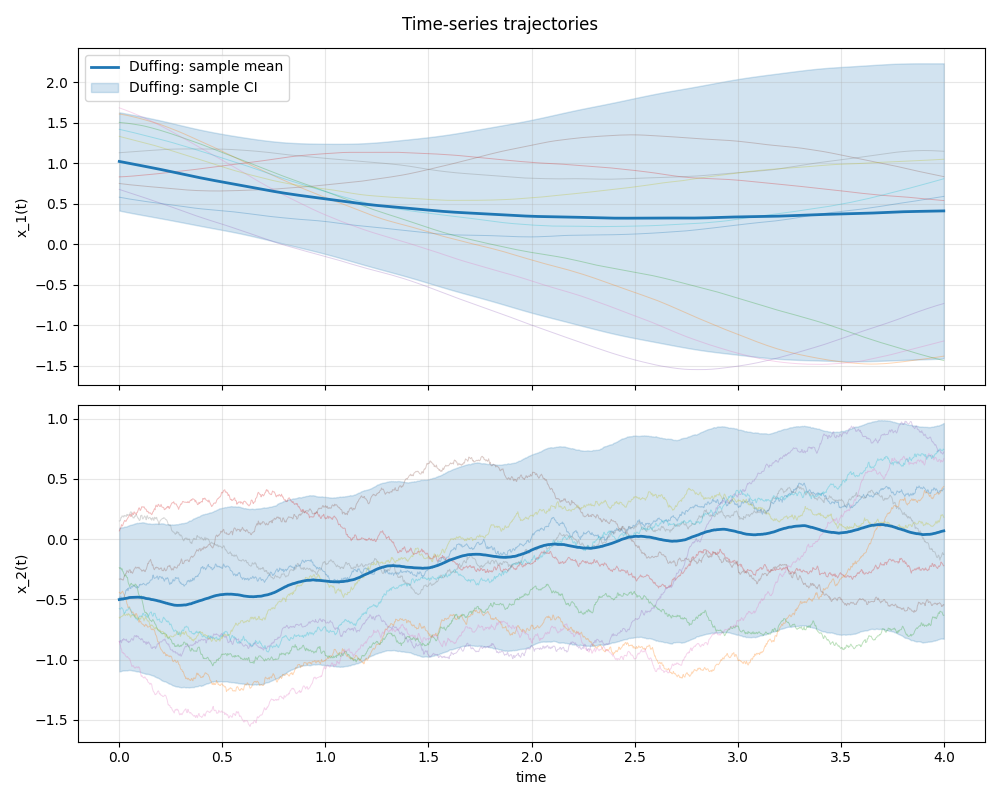

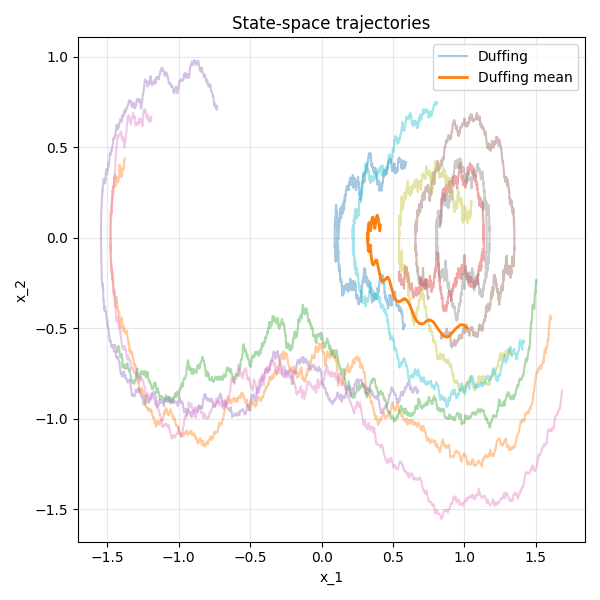

In [6]:
%matplotlib widget
# build the drift/diffusion using the factory (tunable parameters shown)
drift_fn, diffusion_fn = make_duffing_system(
    delta=0.2, alpha=-1.0, beta=1.0, gamma=0.5, omega=5 * torch.pi, noise=0.2
)

def init_sampler(batch_size):
    return torch.randn(batch_size, 2) * 0.3 + torch.tensor([1.0, -0.5])

sampler = TorchSDEDiffusionSampler(
    drift_fn,
    diffusion_fn,
    t0=0.0,
    t1=4.0,
    steps=1500,
    init_sampler=init_sampler,
    method="euler",
)

traj, times, mean_traj = sampler.sample(num_paths=300)

plot_time_series(
    [(times.cpu().numpy(), traj.cpu().numpy())],
    labels=["Duffing"],
    dims=[0, 1],
    plot_mean=True,
    plot_ci=True,
    max_samples=10,
    separate_dims=True,
)

plot_state_space(
    [traj.cpu().numpy()],
    proj_dims=(0, 1),
    labels=["Duffing"],
    max_samples=10,
    plot_mean=True,
)

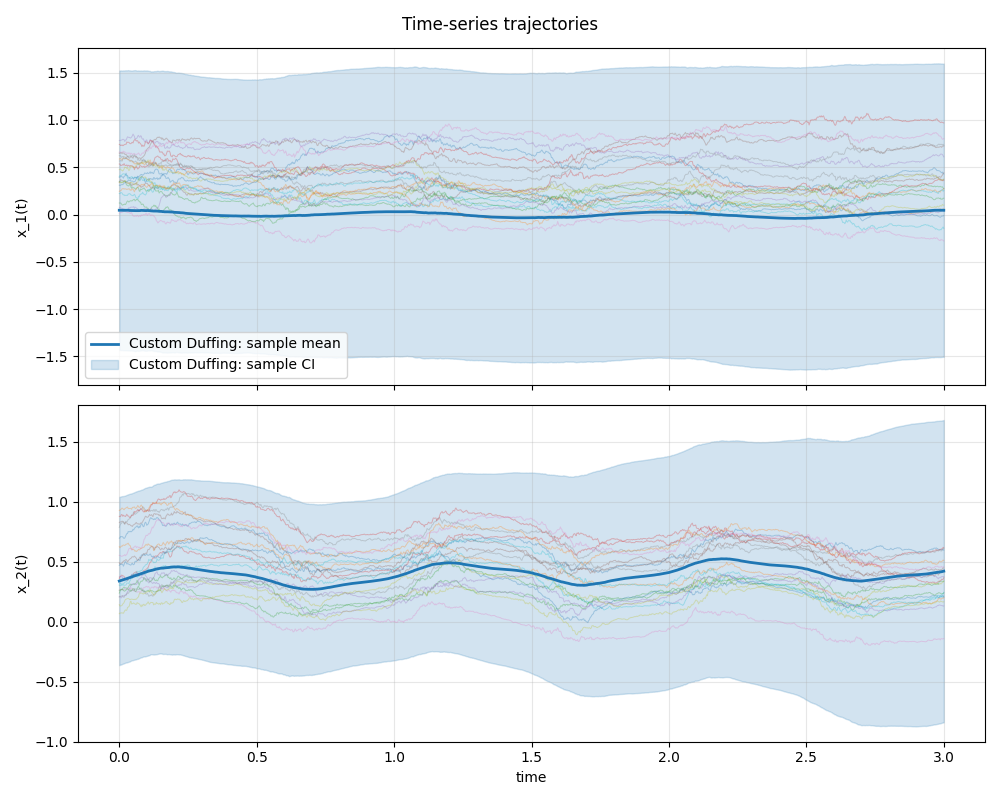

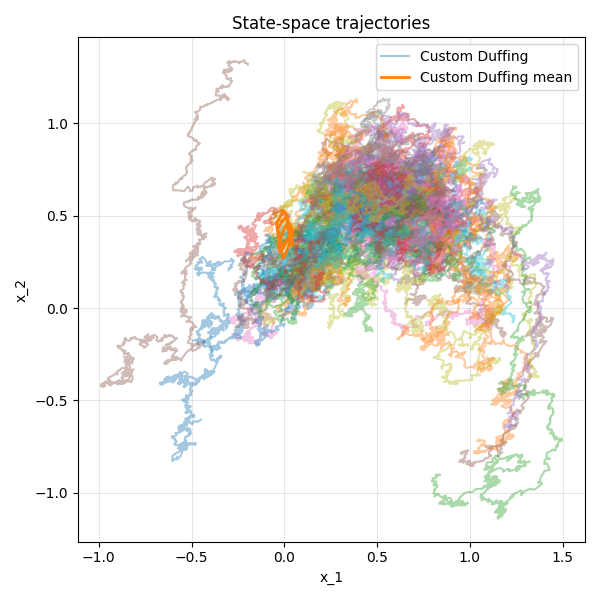

In [7]:
%matplotlib widget
# Build a Duffing-style system with custom forcing/rotation
def custom_duffing_system():
    def drift_fn(t, x):
        x1, x2 = x[:, 0:1], x[:, 1:2]
        dx1 = x2
        dx2 = -0.5 * x2 - x1**3 + 0.3 * torch.sin(6 * torch.pi * t) + 0.6 * torch.cos(2 * torch.pi * t)
        omega = 1.5 * torch.pi * (1 + 0.5 * torch.sin(2 * torch.pi * t))
        swirl = torch.cat([-omega * x2, omega * x1], dim=1)
        return torch.cat([dx1, dx2], dim=1) + 0.2 * swirl

    def diffusion_fn(t, x):
        base = 0.15 + 0.1 * torch.sin(4 * torch.pi * t)
        anis = torch.tensor([[0.8, 0.2], [0.2, 0.5]], device=x.device, dtype=x.dtype)
        chol = torch.linalg.cholesky(anis)
        amp = base + 0.05 * torch.tanh(x.abs().sum(dim=1, keepdim=True))
        return amp.view(-1, 1, 1) * chol.unsqueeze(0).expand(x.size(0), -1, -1)

    return drift_fn, diffusion_fn

drift_fn, diffusion_fn = custom_duffing_system()

def init_sampler(batch_size):
    n1 = int(batch_size * 0.7)
    cloud = torch.randn(n1, 2) * 0.3 + torch.tensor([0.5, 0.5])
    blob = torch.randn(batch_size - n1, 2) * 0.2 + torch.tensor([-1.0, 0.0])
    return torch.cat([cloud, blob], dim=0)

sampler = TorchSDEDiffusionSampler(
    drift_fn,
    diffusion_fn,
    t0=0.0,
    t1=3.0,
    steps=1200,
    init_sampler=init_sampler,
    method="euler",
)

traj, times, mean_traj = sampler.sample(num_paths=300)

plot_time_series(
    [(times.cpu().numpy(), traj.cpu().numpy())],
    labels=["Custom Duffing"],
    dims=[0, 1],
    plot_mean=True,
    plot_ci=True,
    max_samples=20,
    separate_dims=True,
)

plot_state_space(
    [traj.cpu().numpy()],
    proj_dims=(0, 1),
    labels=["Custom Duffing"],
    max_samples=80,
    plot_mean=True,
)

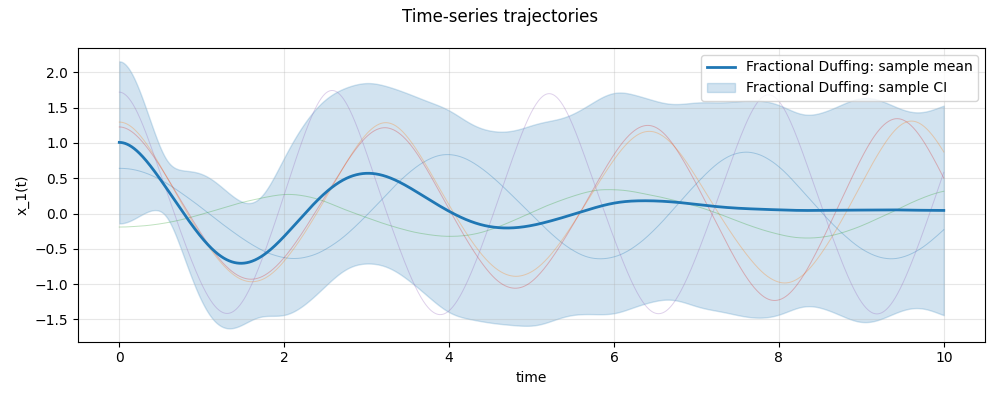

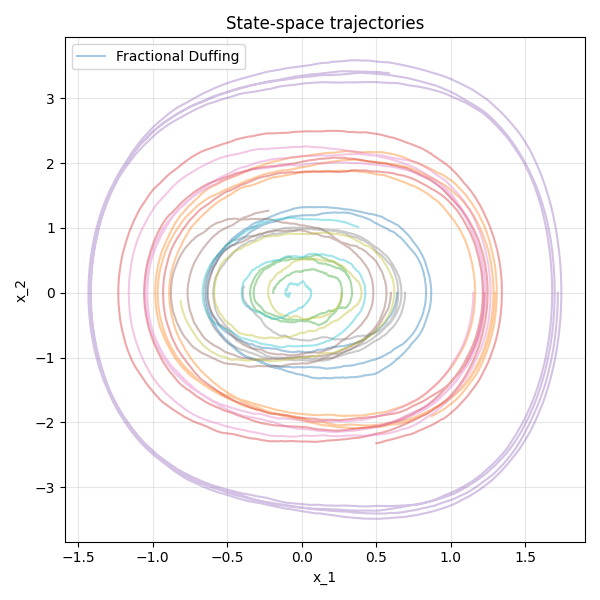

In [16]:
%matplotlib widget
# -------------------------------
# Fractional Duffing Example
# -------------------------------
def simulate_fractional_duffing(
    T=10.0,
    steps=5000,
    batch=200,
    mass=1.0,
    alpha=0.7,
    a=1.0,
    b=1.0,
    hurst=0.8,
    noise_scale=0.6,
    device="cpu",
):
    generator = FractionalNoiseGenerator(hurst, 0.0, T, steps, device=device)
    times = generator.times
    dt = (generator.t1 - generator.t0) / steps

    x = torch.randn(batch, device=device) * 0.5 + 1.0
    v = torch.zeros(batch, device=device)
    x_hist = torch.zeros(batch, steps + 1, device=device)
    v_hist = torch.zeros(batch, steps + 1, device=device)
    x_hist[:, 0] = x
    v_hist[:, 0] = v

    def fractional_kernel(alpha, steps, dt, device="cpu"):
        alpha = torch.tensor(alpha, dtype=torch.float64, device=device)
        k = torch.arange(0, steps, device=device, dtype=torch.float64)
        coeff = torch.exp(torch.lgamma(k - alpha) - torch.lgamma(-alpha) - torch.lgamma(k + 1))
        return (dt ** (-alpha)) * coeff.float()


    fgn = generator.sample_fgn(batch)  # (batch, steps)
    kernel = fractional_kernel(alpha, steps, dt, device=device)
    memory_term = torch.zeros(batch, device=device)

    for n in range(steps):
        if n > 0:
            memory_term = memory_term + kernel[n] * (v_hist[:, n] - v_hist[:, n - 1])
        damping = dt * memory_term

        force = -(a * x + b * x ** 3)
        eta = noise_scale * fgn[:, n]

        v = v + dt * (force / mass) - damping + eta
        x = x + dt * v

        v_hist[:, n + 1] = v
        x_hist[:, n + 1] = x

    return times, x_hist, v_hist

# Example usage
#times, positions, velocities = simulate_fractional_duffing(device="cpu")
times, positions, velocities = simulate_fractional_duffing(
    T=10.0,
    steps=5000,
    batch=200,
    alpha=0.6,
    hurst=0.85,
    noise_scale=1.5,
    mass=0.5,
)

# plot x(t) with mean/CI + a handful of trajectories
traj = torch.stack([positions, velocities], dim=-1).cpu().numpy()
plot_time_series(
    [(times.cpu().numpy(), traj)],
    labels=["Fractional Duffing"],
    dims=[0, 1],                # only the position coordinate
    plot_mean=True,
    plot_ci=True,
    max_samples=5,
    separate_dims=False,
)

# phase plane plot (x,v)
plot_state_space(
    [traj],
    proj_dims=(0, 1),
    labels=["Fractional Duffing"],
    max_samples=10,
    plot_mean=False,
)



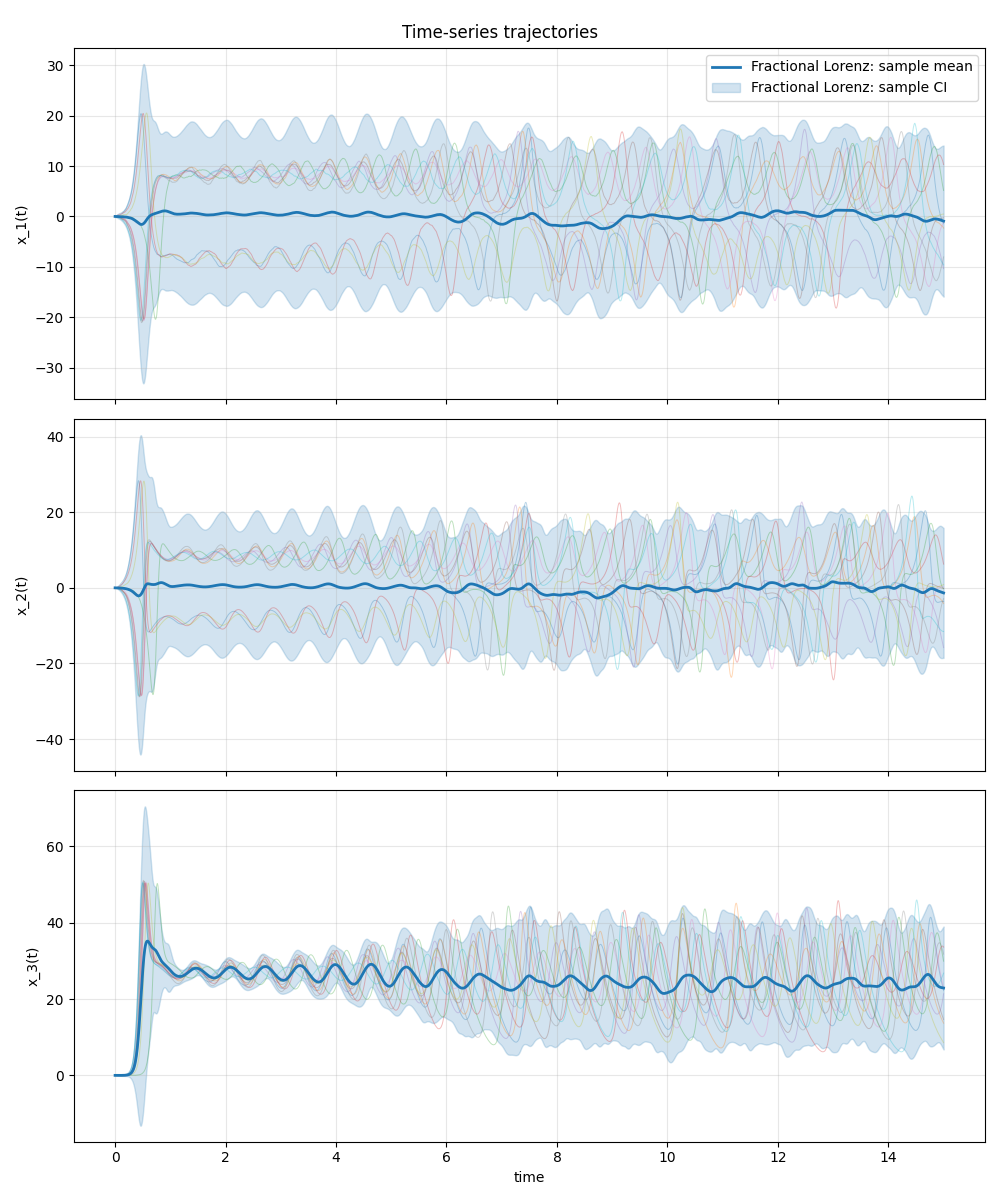

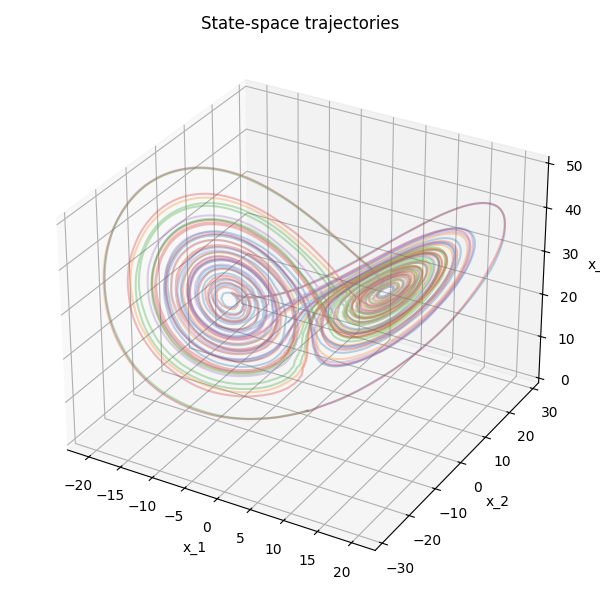

In [20]:
%matplotlib widget
# -------------------------------
# Fractional Lorenz Example
# -------------------------------
sigma, rho, beta = 10.0, 28.0, 8.0 / 3.0

def lorenz_drift(x):
    x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
    dx1 = sigma * (x2 - x1)
    dx2 = x1 * (rho - x3) - x2
    dx3 = x1 * x2 - beta * x3
    return torch.stack([dx1, dx2, dx3], dim=1)

def simulate_fractional_lorenz(hurst=0.8, T=15.0, steps=4000, batch=100, device="cpu"):
    generator = FractionalNoiseGenerator(hurst, 0.0, T, steps, device=device)
    times = generator.times
    dt = (generator.t1 - generator.t0) / steps
    _, fbm = generator.sample_fbm(batch)  # (batch, steps+1)

    x = torch.zeros(batch, 3, device=device)
    traj = torch.zeros(batch, steps + 1, 3, device=device)
    traj[:, 0, :] = x
    noise_scale = 3* torch.tensor([5.5, 1.3, 1.2], device=device)

    for n in range(steps):
        drift = lorenz_drift(x)
        dW = fbm[:, n + 1] - fbm[:, n]
        noise = dW.unsqueeze(-1) * noise_scale
        x = x + drift * dt + noise
        traj[:, n + 1, :] = x
    return times, traj



times, traj = simulate_fractional_lorenz()

plot_time_series(
    [(times.cpu().numpy(), traj.cpu().numpy())],
    labels=["Fractional Lorenz"],
    dims=[0, 1, 2],
    plot_mean=True,
    plot_ci=True,
    max_samples=10,
    separate_dims=True,
)

plot_state_space(
    [traj.cpu().numpy()],
    proj_dims=(0, 1, 2),
    labels=["Fractional Lorenz"],
    max_samples=5,
    plot_mean=False,
)

In [10]:
# def fractional_gaussian_noise(H, steps, dt, batch, device="cpu"):
#     """Davies–Harte generator for fGn (returns batch × steps)."""
#     N = steps
#     t = torch.arange(0, N, device=device, dtype=torch.float64)
#     r = 0.5 * ((t + 1)**(2 * H) - 2 * t**(2 * H) + (torch.abs(t - 1))**(2 * H))
#     r = torch.cat([r, torch.flip(r[1:-1], dims=[0])], dim=0)
#     eigs = torch.fft.rfft(r).real
#     eigs = torch.clamp(eigs, min=0.0)  # numerical safety
#     Z = torch.randn(batch, eigs.shape[0]*2, device=device, dtype=torch.float64)
#     Z[:, eigs.shape[0]:] = torch.randn_like(Z[:, eigs.shape[0]:])
#     W = torch.complex(Z[:, :eigs.shape[0]], Z[:, eigs.shape[0]:])
#     fgn = torch.fft.irfft(torch.sqrt(eigs)[None, :] * W, n=r.numel(), dim=-1)
#     fgn = fgn[:, :N] * (dt**H)
#     return fgn.float()

# def fractional_lorenz(T=10.0, steps=4000, batch=200,
#                       alpha=0.6, H=0.8, noise_scale=(2.0, 1.2, 0.8), device="cpu"):
#     dt = T / steps
#     times = torch.linspace(0, T, steps + 1, device=device)
#     kernel = fractional_kernel(alpha, steps, dt, device=device)

#     x = torch.empty(batch, 3, device=device).uniform_(-10, 10)
#     x_hist = torch.zeros(batch, steps + 1, 3, device=device)
#     x_hist[:, 0] = x

#     fgn = fractional_gaussian_noise(H, steps, dt, batch, device=device)
#     memory = torch.zeros(batch, 3, device=device)

#     for n in range(steps):
#         if n > 0:
#             memory += kernel[n] * (x_hist[:, n] - x_hist[:, n-1])
#         drift = lorenz_drift(x)  # same as before
#         dW = fgn[:, n].unsqueeze(-1) * torch.tensor(noise_scale, device=device)
#         x = x + drift * dt - memory * dt + dW
#         x_hist[:, n+1] = x
#     return times, x_hist

# def fractional_kernel(alpha, steps, dt, device="cpu"):
#     alpha = torch.tensor(alpha, dtype=torch.float64, device=device)
#     k = torch.arange(0, steps, device=device, dtype=torch.float64)
#     coeff = torch.exp(torch.lgamma(k - alpha) - torch.lgamma(-alpha) - torch.lgamma(k + 1))
#     return (dt ** (-alpha)) * coeff.float()

# def simulate_fractional_duffing(
#     T=10.0,
#     steps=5000,
#     batch=200,
#     mass=1.0,
#     alpha=0.7,
#     a=1.0,
#     b=1.0,
#     H=0.8,
#     noise_scale=0.6,
#     device="cpu",
# ):
#     dt = T / steps
#     times = torch.linspace(0, T, steps + 1, device=device)
#     kernel = fractional_kernel(alpha, steps, dt, device=device)  # memory weights

#     # initial conditions: random around one well
#     x = torch.randn(batch, device=device) * 0.5 + 1.0
#     v = torch.zeros(batch, device=device)
#     x_hist = torch.zeros(batch, steps + 1, device=device)
#     v_hist = torch.zeros(batch, steps + 1, device=device)
#     x_hist[:, 0] = x
#     v_hist[:, 0] = v

#     # fractional Gaussian noise increments
#     fgn = fractional_gaussian_noise(H, steps, dt, batch, device=device)

#     memory_term = torch.zeros(batch, device=device)
#     for n in range(steps):
#         # update memory (Grünwald sum)
#         if n > 0:
#             memory_term = memory_term + kernel[n] * (v_hist[:, n] - v_hist[:, n - 1])
#         damping = dt * memory_term

#         # Duffing potential gradient
#         force = -(a * x + b * x**3)

#         # fractional noise increment
#         eta = noise_scale * fgn[:, n]

#         # velocity/position update (semi-implicit Euler)
#         v = v + dt * (force / mass) - damping + eta
#         x = x + dt * v

#         v_hist[:, n + 1] = v
#         x_hist[:, n + 1] = x

#     return times, x_hist, v_hist

# # Example usage
# #times, positions, velocities = simulate_fractional_duffing(device="cpu")
# times, positions, velocities = simulate_fractional_duffing(
#     T=10.0,
#     steps=5000,
#     batch=200,
#     alpha=0.6,
#     H=0.85,
#     noise_scale=1.5,
#     mass=0.5,
# )

# # plot x(t) with mean/CI + a handful of trajectories
# plot_time_series(
#     [(times.cpu().numpy(), positions.unsqueeze(-1).cpu().numpy())],
#     labels=["Fractional Duffing"],
#     dims=[0],                # only the position coordinate
#     plot_mean=True,
#     plot_ci=True,
#     max_samples=5,
#     separate_dims=False,
# )

# # phase plane plot (x,v)
# traj = torch.stack([positions, velocities], dim=-1)
# plot_state_space(
#     [traj.cpu().numpy()],
#     proj_dims=(0, 1),
#     labels=["Fractional Duffing"],
#     max_samples=80,
#     plot_mean=False,
# )

In [11]:
# def fractional_brownian_motion(H, T, steps, batch_size, device=None):
#     """Simple Davie-Harte style generator for R^1 fBm; extendable to more dims."""
#     device = device or "cpu"
#     times = torch.linspace(0, T, steps + 1, device=device)
#     dt = T / steps

#     # Fast way via cumulative sum of fractional Gaussian noise.
#     # Here we approximate increments with correlated Gaussian noise using a Toeplitz covariance.
#     # For brevity, we use torch.distributions to sample from the covariance directly.
#     cov = torch.zeros(steps + 1, steps + 1, device=device)
#     for i in range(steps + 1):
#         for j in range(steps + 1):
#             cov[i, j] = 0.5 * (abs(i * dt)**(2*H) + abs(j*dt)**(2*H) - abs(i*dt - j*dt)**(2*H))
#     cov += 1e-6 * torch.eye(steps + 1, device=device)
#     mean = torch.zeros(steps + 1, device=device)
#     mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
#     samples = mvn.sample((batch_size,))  # (batch, steps+1)
#     return times, samples

# # Fractional-Lorenz drift
# sigma = 10.0
# rho = 28.0
# beta = 8.0 / 3.0

# def lorenz_drift(x):
#     x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
#     dx1 = sigma * (x2 - x1)
#     dx2 = x1 * (rho - x3) - x2
#     dx3 = x1 * x2 - beta * x3
#     return torch.stack([dx1, dx2, dx3], dim=1)

# def simulate_fractional_lorenz(H=0.8, T=10.0, steps=4000, num_paths=100):
#     device = "cpu"
#     times, fbm = fractional_brownian_motion(H, T, steps, num_paths, device=device)
#     dt = T / steps
#     x = torch.zeros(num_paths, 3, device=device)
#     trajectories = torch.zeros(num_paths, steps + 1, 3, device=device)
#     trajectories[:, 0, :] = x

#     for n in range(steps):
#         drift = lorenz_drift(x)
#         # fractional increments (difference of fBm)
#         dW = fbm[:, n+1] - fbm[:, n]
#         noise = dW.unsqueeze(-1) * torch.tensor([0.5, 0.3, 0.2], device=device)
#         x = x + drift * dt + noise
#         trajectories[:, n+1, :] = x
#     return times, trajectories

# times, traj = simulate_fractional_lorenz()

# plot_time_series(
#     [(times.cpu().numpy(), traj.cpu().numpy())],
#     labels=["Fractional Lorenz"],
#     dims=[0, 1, 2],
#     plot_mean=True,
#     plot_ci=True,
#     max_samples=10,
#     separate_dims=True,
# )

# plot_state_space(
#     [traj.cpu().numpy()],
#     proj_dims=(0, 1),
#     labels=["Fractional Lorenz"],
#     max_samples=50,
#     plot_mean=False,
# )

In [12]:
# def fractional_gaussian_noise(H, steps, batch_size, device):
#     gamma0 = 1.0
#     gamma = [
#         0.5 * ((k + 1) ** (2 * H) - 2 * k ** (2 * H) + abs(k - 1) ** (2 * H))
#         for k in range(steps)
#     ]
#     fgn = torch.zeros(batch_size, steps, device=device)
#     cov = torch.tensor(gamma, device=device)
#     for b in range(batch_size):
#         # Hosking's method
#         V = torch.zeros(steps, steps, device=device)
#         V[0, 0] = cov[0]
#         phi = torch.zeros(steps, device=device)
#         phi[0] = cov[0]
#         noise = torch.randn(steps, device=device)
#         fgn_sample = torch.zeros(steps, device=device)
#         fgn_sample[0] = noise[0] * torch.sqrt(V[0, 0])
#         for n in range(1, steps):
#             #phi[:n] = cov[n - 1::-1]
#             phi[:n] = torch.flip(cov[:n], dims=[0])
#             if n > 1:
#                 phi[:n-1] -= torch.matmul(V[n-1, :n-1], phi[:n-1])
#                 phi[:n-1] /= V[:n-1, :n-1].diag()
#             V[n, n] = cov[0] - torch.dot(phi[:n], cov[:n])
#             fgn_sample[n] = noise[n] * torch.sqrt(V[n, n])
#         fgn[b] = fgn_sample
#     return fgn


# # Fractional-Lorenz drift
# sigma = 10.0
# rho = 28.0
# beta = 8.0 / 3.0

# def lorenz_drift(x):
#     x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
#     dx1 = sigma * (x2 - x1)
#     dx2 = x1 * (rho - x3) - x2
#     dx3 = x1 * x2 - beta * x3
#     return torch.stack([dx1, dx2, dx3], dim=1)

# def simulate_fractional_lorenz(H=0.8, T=10.0, steps=4000, num_paths=100):
#     device = "cpu"
#     dt = T / steps
#     fgn = fractional_gaussian_noise(H, steps, num_paths, device=device)
#     fbm = torch.cumsum(torch.cat([torch.zeros(num_paths, 1, device=device), fgn], dim=1), dim=1)
#     times = torch.linspace(0, T, steps + 1, device=device)

#     #x = torch.zeros(num_paths, 3, device=device)
#     x = torch.empty(num_paths, 3).uniform_(-10, 10)
#     traj = torch.zeros(num_paths, steps + 1, 3, device=device)
#     traj[:, 0, :] = x
#     noise_scale = torch.tensor([2.5, 1.5, 1.0], device=device)

#     for n in range(steps):
#         drift = lorenz_drift(x)
#         dW = fbm[:, n+1] - fbm[:, n]
#         noise = dW.unsqueeze(-1) * noise_scale
#         x = x + drift * dt + noise
#         traj[:, n+1, :] = x
#     return times, traj


# times, traj = simulate_fractional_lorenz()

# # Plot per dimension
# plot_diffusion_stats(times.cpu().numpy(), traj.cpu().numpy(), num_std=2)
# # Plot projection onto x1-x2 plane
# plot_diffusion_trajectories(traj.cpu().numpy(), dims=(0, 1), max_traj=50, alpha=0.4)

In [13]:
# #### OLD STUFF
# def plot_diffusion_stats(times, samples, num_std=2):
#     """
#     Empirical mean ± num_std·std per dimension vs. time.
#     samples: (N, T, d); times: (T,)
#     """
#     times = np.asarray(times)
#     samples = np.asarray(samples)
#     N, T, d = samples.shape

#     sample_mean = samples.mean(axis=0)
#     sample_std = samples.std(axis=0, ddof=1)

#     fig, axes = plt.subplots(d, 1, figsize=(8, 3 * d), sharex=True)
#     axes = np.atleast_1d(axes)

#     for j in range(d):
#         ax = axes[j]
#         ax.plot(times, sample_mean[:, j], color="tab:orange", lw=2, label="Sample mean")
#         ax.fill_between(times,
#                         sample_mean[:, j] - num_std * sample_std[:, j],
#                         sample_mean[:, j] + num_std * sample_std[:, j],
#                         color="tab:orange", alpha=0.2,
#                         label=f"Sample ± {num_std}σ" if j == 0 else None)
#         ax.set_ylabel(f"x_{j+1}(t)")
#         ax.grid(True, alpha=0.3)
#         if j == 0:
#             ax.legend(loc="upper right")
#     axes[-1].set_xlabel("time")
#     plt.tight_layout()
#     plt.show()


# def plot_diffusion_trajectories(samples, dims=(0, 1), max_traj=100, alpha=0.4):
#     """
#     Overlay sample paths in ℝᵈ (projecting onto dims if d>2).
#     """
#     samples = np.asarray(samples)
#     N, T, d = samples.shape
#     if len(dims) != 2:
#         raise ValueError("dims must be a pair of coordinate indices.")
#     if max(dims) >= d:
#         raise ValueError(f"dims {dims} exceed sample dimension {d}.")

#     fig, ax = plt.subplots(figsize=(6, 6))
#     for i in range(min(max_traj, N)):
#         ax.plot(samples[i, :, dims[0]], samples[i, :, dims[1]], alpha=alpha)
#     ax.set_xlabel(f"x_{dims[0]+1}")
#     ax.set_ylabel(f"x_{dims[1]+1}")
#     ax.set_title(f"{min(max_traj, N)} diffusion trajectories")
#     ax.grid(True, alpha=0.3)
#     plt.show()

# class DiffusionSampler:
#     """
#     Euler–Maruyama sampler for d-dimensional SDEs on [t0, t1].

#     Args:
#         drift_fn: b(t, x) -> (batch, d)
#         diffusion_fn: σ(t, x) -> (batch, d, m)
#         t0, t1: float
#         steps: int
#         init_sampler: callable that accepts num_paths and returns (num_paths, d)
#                      initial states, or None to start from a fixed x0.
#     """
#     def __init__(self, drift_fn, diffusion_fn, t0, t1, steps, init_sampler=None):
#         self.drift_fn = drift_fn
#         self.diffusion_fn = diffusion_fn
#         self.t0 = float(t0)
#         self.t1 = float(t1)
#         self.steps = steps
#         self.dt = (self.t1 - self.t0) / steps
#         self.init_sampler = init_sampler

#     @torch.no_grad()
#     def sample(self, x0=None, num_paths=1, flatten=False):
#         """
#         Args:
#             x0: tensor (d,) if init_sampler is None; ignored otherwise.
#             num_paths: number of trajectories.
#             flatten: return (N, (steps+1)*d) if True, else (N, steps+1, d)

#         Returns:
#             trajectories, times
#         """
#         if self.init_sampler is not None:
#             x_init = self.init_sampler(num_paths)
#         else:
#             if x0 is None:
#                 raise ValueError("Provide x0 when init_sampler is None.")
#             x_init = x0.expand(num_paths, -1)

#         x_init = x_init.to(torch.float32)
#         num_paths, d = x_init.shape
#         traj = torch.zeros(num_paths, self.steps + 1, d, dtype=x_init.dtype, device=x_init.device)
#         traj[:, 0, :] = x_init

#         x = x_init.clone()
#         sqrt_dt = self.dt ** 0.5
#         times = torch.linspace(self.t0, self.t1, self.steps + 1, device=x_init.device)

#         for n in range(self.steps):
#             t = times[n]
#             drift = self.drift_fn(t, x)                      # (N, d)
#             sigma = self.diffusion_fn(t, x)                  # (N, d, m)
#             dW = torch.randn(num_paths, sigma.shape[-1], device=x.device) * sqrt_dt
#             x = x + drift * self.dt + torch.bmm(sigma, dW.unsqueeze(-1)).squeeze(-1)
#             traj[:, n + 1, :] = x

#         if flatten:
#             return traj.view(num_paths, -1), times
#         return traj, times
    

# # d = 2
# # # Example: Gaussian initial state N(μ0, Σ0)
# # mu0 = torch.tensor([0.0, 0.0])
# # Sigma0 = torch.tensor([[1.0, 0.5],
# #                        [0.5, 1.5]])

# # def init_sampler(batch_size):
# #     mvn = torch.distributions.MultivariateNormal(mu0, covariance_matrix=Sigma0)
# #     return mvn.sample((batch_size,))

# # def drift_fn(t, x):
# #     omega = 2.0 * torch.pi
# #     rot = torch.tensor([[0.0, -omega],
# #                         [omega, 0.0]], device=x.device)
# #     return x @ rot.T - 0.2 * x   # rotation + damping

# # def diffusion_fn(t, x):
# #     amp = 0.3 + 0.1 * torch.sin(4 * torch.pi * t)
# #     return amp * torch.eye(d, device=x.device).unsqueeze(0).expand(x.size(0), -1, -1)

# # sampler = DiffusionSampler(drift_fn, diffusion_fn, t0=0.0, t1=1.0, steps=500,
# #                            init_sampler=init_sampler)
# # traj, times = sampler.sample(num_paths=256)

# # plot_diffusion_stats(times, traj, num_std=2)
# # plot_diffusion_trajectories(traj, dims=(0, 1), max_traj=60)


# # # Drift: swirl plus double-well attraction
# # def drift_fn(t, x):
# #     # rotation matrix
# #     omega = 4 * torch.pi
# #     rot = torch.tensor([[0.0, -omega],
# #                         [omega, 0.0]], device=x.device, dtype=x.dtype)
# #     swirl = x @ rot.T
# #     # double-well potential centered at (±1, 0)
# #     wells = torch.tensor([[1.5, 0.0],
# #                           [-1.5, 0.0]], device=x.device, dtype=x.dtype)
# #     attraction = (wells.unsqueeze(0) - x.unsqueeze(1)).norm(dim=-1, keepdim=True)
# #     attract = (wells - x.unsqueeze(1)) * attraction
# #     attract = attract.mean(dim=1)
# #     return swirl - 0.5 * x + 0.6 * attract

# # # Diffusion: anisotropic, time-varying
# # def diffusion_fn(t, x):
# #     base = 0.2 + 0.1 * torch.sin(6 * torch.pi * t)
# #     anis = torch.tensor([[1.0, 0.3],
# #                          [0.3, 0.5]], device=x.device, dtype=x.dtype)
# #     chol = torch.linalg.cholesky(anis)
# #     sigma = base * chol
# #     return sigma.unsqueeze(0).expand(x.size(0), -1, -1)

# # # Init sampler: ring distribution
# # def init_sampler(batch_size):
# #     angles = torch.rand(batch_size) * 2 * torch.pi
# #     radii = 1.5 + 0.2 * torch.randn(batch_size)
# #     x0 = torch.stack([radii * torch.cos(angles), radii * torch.sin(angles)], dim=-1)
# #     return x0.to(torch.float32)

# # sampler = DiffusionSampler(drift_fn, diffusion_fn, t0=0.0, t1=3.0, steps=1000,
# #                            init_sampler=init_sampler)

# # traj, times = sampler.sample(num_paths=300, flatten=False)
# # plot_diffusion_stats(times.cpu().numpy(), traj.cpu().numpy(), num_std=2)
# # plot_diffusion_trajectories(traj.cpu().numpy(), dims=(0, 1), max_traj=80)


# # def drift_fn(t, x):
# #     # x: (N, 2)
# #     # nonlinear “butterfly” drift: two opposing potentials + swirl
# #     x1, x2 = x[:, 0:1], x[:, 1:2]
# #     r2 = x1**2 + x2**2
# #     # swirl component with time-varying angular speed
# #     omega = 6 * torch.pi * (0.5 + 0.5 * torch.sin(2 * torch.pi * t))
# #     swirl = torch.cat([-omega * x2, omega * x1], dim=1)
# #     # quartic double-well potential in x1, cubic in x2
# #     pot_x1 = -x1 + x1**3
# #     pot_x2 = -x2 + x2**3
# #     # radial push that flips sign across a ring
# #     radial = 0.6 * (1.0 - r2) * x
# #     return swirl - pot_x1 * torch.tensor([1.0, 0.0], device=x.device) - pot_x2 * torch.tensor([0.0, 1.0], device=x.device) + radial

# # def diffusion_fn(t, x):
# #     # anisotropic noise that pulses with time and state magnitude
# #     base = 0.25 + 0.15 * torch.sin(4 * torch.pi * t)
# #     r = torch.norm(x, dim=1, keepdim=True)
# #     amp = base + 0.1 * torch.tanh(r)
# #     # rotate diffusion axis over time
# #     angle = torch.pi * t
# #     c, s = torch.cos(angle), torch.sin(angle)
# #     R = torch.tensor([[c, -s], [s, c]], device=x.device, dtype=x.dtype)
# #     Sigma = torch.tensor([[1.0, 0.6], [0.6, 0.4]], device=x.device, dtype=x.dtype)
# #     chol = torch.linalg.cholesky(Sigma)
# #     A = R @ chol
# #     return amp.view(-1, 1, 1) * A.unsqueeze(0).expand(x.size(0), -1, -1)

# # def init_sampler(batch_size):
# #     # random ring + gaussian blob mixing
# #     n_ring = batch_size // 2
# #     n_blob = batch_size - n_ring
# #     angles = torch.rand(n_ring) * 2 * torch.pi
# #     radii = 2.0 + 0.4 * torch.randn(n_ring)
# #     ring = torch.stack([radii * torch.cos(angles), radii * torch.sin(angles)], dim=-1)
# #     blob = torch.randn(n_blob, 2) * 0.5
# #     return torch.cat([ring, blob], dim=0).to(torch.float32)

# # sampler = DiffusionSampler(drift_fn, diffusion_fn, t0=0.0, t1=4.0, steps=1500, init_sampler=init_sampler)

# # traj, times = sampler.sample(num_paths=400, flatten=False)
# # plot_diffusion_stats(times.cpu().numpy(), traj.cpu().numpy(), num_std=2)
# # plot_diffusion_trajectories(traj.cpu().numpy(), dims=(0, 1), max_traj=120, alpha=0.3)

# sigma_l = 10.0
# rho = 28.0
# beta = 8.0 / 3.0

# def drift_fn(t, x):
#     # x shape: (N, 3)
#     x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
#     dx1 = sigma_l * (x2 - x1)
#     dx2 = x1 * (rho - x3) - x2
#     dx3 = x1 * x2 - beta * x3
#     return torch.stack([dx1, dx2, dx3], dim=1)

# def diffusion_fn(t, x):
#     # isotropic noise scaled by state magnitude
#     scale = 0.5 + 0.1 * torch.norm(x, dim=1, keepdim=True)
#     return torch.eye(3).unsqueeze(0).expand(x.size(0), 3, 3) * scale.unsqueeze(-1)

# def init_sampler(batch_size):
#     return torch.empty(batch_size, 3).uniform_(-15, 15)

# sampler = DiffusionSampler(drift_fn, diffusion_fn, t0=0.0, t1=10.0, steps=5000,
#                            init_sampler=init_sampler)

# traj, times = sampler.sample(num_paths=5, flatten=False)
# # Plot stats per dimension
# plot_diffusion_stats(times.cpu().numpy(), traj.cpu().numpy(), num_std=2)
# # Plot trajectories projected to x1-x2 plane
# plot_diffusion_trajectories(traj.cpu().numpy(), dims=(0, 1), max_traj=5, alpha=0.4)